In [1]:
import torch
from torch import nn
import numpy as np
import random
import matplotlib.pyplot as plt
from relaxed_gconv import TimeRevNet
from utils import Dataset2DTime, train_model_batch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Generate Pendulum Dataset

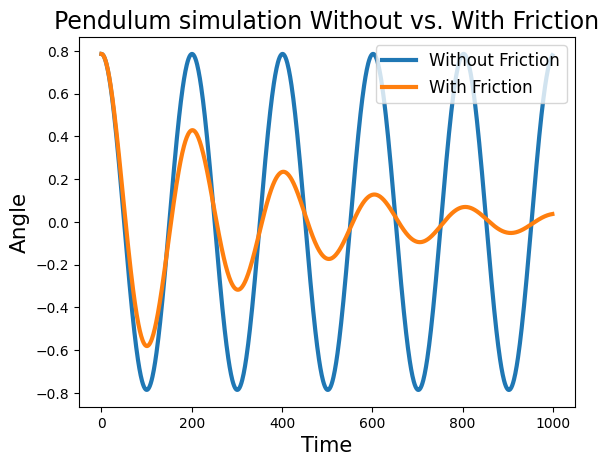

In [3]:
def pendulum_simulator(length, g, beta, theta0, omega0, num_steps, dt, with_friction=True):
    """
    Simulates a pendulum motion with or without friction.

    Args:
    length (float): Length of the pendulum (L).
    g (float): Acceleration due to gravity.
    beta (float): Damping coefficient. Only used if with_friction is True.
    theta0 (float): Initial angular displacement (in radians).
    omega0 (float): Initial angular velocity (in radians per second).
    num_steps (int): Number of simulation steps.
    dt (float): Time step for simulation.
    with_friction (bool): Simulate with friction if True, otherwise simulate without friction.

    Returns:
    numpy.ndarray: Array of shape (num_steps, 2) with [theta, omega] at each time step.
    """
    def damped_pendulum_derivatives(theta, omega):
        """Derivatives for the damped pendulum."""
        return omega, -2 * beta * omega - (g / length) * theta

    def undamped_pendulum_derivatives(theta, omega):
        """Derivatives for the undamped pendulum."""
        return omega, -(g / length) * theta

    # Choose the appropriate derivative function based on whether there's friction
    derivatives_func = damped_pendulum_derivatives if with_friction else undamped_pendulum_derivatives

    # Initialize the array to store [theta, omega] at each step
    results = np.zeros((num_steps, 2))
    theta, omega = theta0, omega0

    for i in range(num_steps):
        results[i] = [theta, omega]

        # Calculate the derivatives
        dtheta, domega = derivatives_func(theta, omega)

        # Update theta and omega using Euler's method
        theta += dtheta * dt
        omega += domega * dt

    return results

# Example parameters for the simulation
length = 1.0  # length of the pendulum in meters
g = 9.81      # acceleration due to gravity in m/s^2
beta = 0.3    # damping coefficient
theta0 = np.pi / 4  # initial angle (45 degrees in radians)
omega0 = 0.0  # initial angular velocity
num_steps = 1000000
dt = 0.00001  # time step

# Simulate both damped and undamped pendulums
undamped_results = pendulum_simulator(length, g, beta, theta0, omega0, num_steps, dt, with_friction=False)
damped_results = pendulum_simulator(length, g, beta, theta0, omega0, num_steps, dt, with_friction=True)

# Display the first few rows of each result for demonstration
undamped = undamped_results[::1000, :1].reshape(1, 1000, 1)
damped = damped_results[::1000, :1].reshape(1, 1000, 1)
np.save("data/pendulum/pendulum_undamped.npy", undamped)
np.save("data/pendulum/pendulum_damped.npy", damped)

plt.plot(undamped[0,:,0], label = "Without Friction", linewidth = 3)
plt.plot(damped[0,:,0], label = "With Friction", linewidth = 3)
plt.xlabel("Time", size = 15)
plt.ylabel("Angle", size = 15.5)
plt.legend(fontsize = 12)
plt.title("Pendulum simulation Without vs. With Friction", size = 17)
plt.show()

## 2. Discover Time Reversal Symmetry

In [5]:
kernel_size = 5
hidden_dim = 4
num_filter_basis = 1
batch_size = 16
learning_rate = 0.001
decay_rate = 0.95
num_epoch = 100
in_channels = 1
out_channels = 1
train_indices = np.arange(0, 800)
valid_indices = np.arange(800, 1000)
length = 8
direc = "data/pendulum/"

all_undamped_weights = []
all_damped_weights = []
for seed in range(10):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.use_deterministic_algorithms(True)
    undamped_train_set = Dataset2DTime(direc = direc + "pendulum_undamped.npy", sample_list = train_indices, length = length)
    undamped_valid_set = Dataset2DTime(direc = direc + "pendulum_undamped.npy", sample_list = valid_indices, length = length)

    undamped_train_loader = torch.utils.data.DataLoader(undamped_train_set, batch_size = batch_size, shuffle = True, num_workers = 0)
    undamped_valid_loader = torch.utils.data.DataLoader(undamped_valid_set, batch_size = batch_size, shuffle = False, num_workers = 0)  

    undamped_model = TimeRevNet(in_channels = in_channels, 
                                out_channels = out_channels, 
                                kernel_size = kernel_size, 
                                hidden_dim = hidden_dim, 
                                num_filter_basis = num_filter_basis).to(device)
    undamped_best_model = train_model_batch(undamped_model, undamped_train_loader, undamped_valid_loader, num_epoch, learning_rate, decay_rate)
    undamped_weights = torch.stack([undamped_best_model.model[i].relaxed_weights for i in range(3)]).cpu().data.numpy()
    all_undamped_weights.append(undamped_weights)

    damped_train_set = Dataset2DTime(direc = direc + "pendulum_damped.npy", sample_list = train_indices, length = length)
    damped_valid_set = Dataset2DTime(direc = direc + "pendulum_damped.npy", sample_list = valid_indices, length = length)

    damped_train_loader = torch.utils.data.DataLoader(damped_train_set, batch_size = batch_size, shuffle = True, num_workers = 0)
    damped_valid_loader = torch.utils.data.DataLoader(damped_valid_set, batch_size = batch_size, shuffle = False, num_workers = 0)  

    damped_model = TimeRevNet(in_channels = in_channels, 
                              out_channels = out_channels, 
                              kernel_size = kernel_size, 
                              hidden_dim = hidden_dim, 
                              num_filter_basis = num_filter_basis).to(device)
    damped_best_model = train_model_batch(damped_model, damped_train_loader, damped_valid_loader, num_epoch, learning_rate, decay_rate)
    damped_weights = torch.stack([damped_best_model.model[i].relaxed_weights for i in range(3)]).cpu().data.numpy()
    all_damped_weights.append(damped_weights)
   
all_damped_weights = np.array(all_damped_weights).transpose(1,0,2,3)
all_undamped_weights = np.array(all_undamped_weights).transpose(1,0,2,3)

Epoch 1 | T: 0.04 | Train MAE: 0.27987 | Valid MAE: 0.17667 | LR 0.000950
Epoch 11 | T: 0.00 | Train MAE: 0.01716 | Valid MAE: 0.01718 | LR 0.000569
Epoch 21 | T: 0.00 | Train MAE: 0.00871 | Valid MAE: 0.00825 | LR 0.000341
Epoch 31 | T: 0.00 | Train MAE: 0.00387 | Valid MAE: 0.00348 | LR 0.000204
Epoch 41 | T: 0.00 | Train MAE: 0.00166 | Valid MAE: 0.00157 | LR 0.000122
Epoch 51 | T: 0.00 | Train MAE: 0.00131 | Valid MAE: 0.00125 | LR 0.000073
Epoch 61 | T: 0.00 | Train MAE: 0.00115 | Valid MAE: 0.00110 | LR 0.000044
Epoch 71 | T: 0.00 | Train MAE: 0.00107 | Valid MAE: 0.00103 | LR 0.000026
Epoch 81 | T: 0.00 | Train MAE: 0.00103 | Valid MAE: 0.00099 | LR 0.000016
Epoch 91 | T: 0.00 | Train MAE: 0.00100 | Valid MAE: 0.00096 | LR 0.000009
Epoch 1 | T: 0.00 | Train MAE: 0.05409 | Valid MAE: 0.09649 | LR 0.000950
Epoch 11 | T: 0.00 | Train MAE: 0.00391 | Valid MAE: 0.01088 | LR 0.000569
Epoch 21 | T: 0.00 | Train MAE: 0.00248 | Valid MAE: 0.00693 | LR 0.000341
Epoch 31 | T: 0.00 | Train 

Text(0.5, 0.98, 'Relaxed Weights for Time Reversal Symmetry of Pendulum')

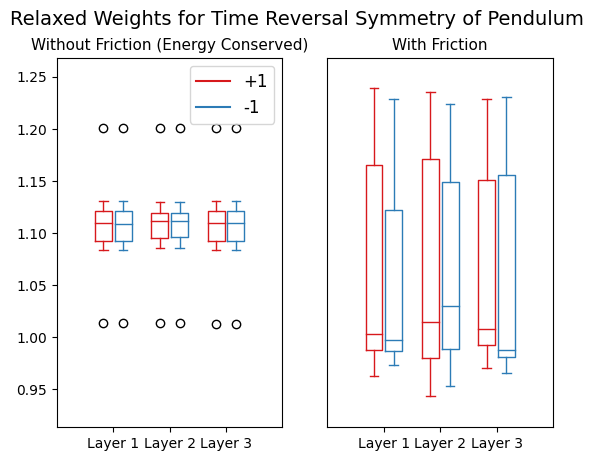

In [7]:
ticks = ['Layer 1', 'Layer 2', 'Layer 3']
def define_box_properties(plot_name, color_code, label, leg = False):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
         
    # use plot function to draw a small line to name the legend.
    plt.plot([], c=color_code, label=label)
    if leg:
        plt.legend(fontsize = 12)
        
max_lim = np.max([np.max(all_undamped_weights), np.max(all_damped_weights)])
min_lim = np.min([np.min(all_undamped_weights), np.min(all_damped_weights)])
space = (max_lim - min_lim)/10

plt.subplot(1,2,1)
summer_rain = list(all_undamped_weights[:,:,:,0].mean(-1))
winter_rain = list(all_undamped_weights[:,:,:,1].mean(-1))
 
summer_rain_plot = plt.boxplot(summer_rain,
                               positions=np.array(
    np.arange(len(summer_rain)))*2.0-0.35, 
                               widths=0.6)
winter_rain_plot = plt.boxplot(winter_rain,
                               positions=np.array(
    np.arange(len(winter_rain)))*2.0+0.35,
                               widths=0.6)
 
# setting colors for each groups
define_box_properties(summer_rain_plot, '#D7191C', '+1', leg = True)
define_box_properties(winter_rain_plot, '#2C7BB6', '-1', leg = True)
 
# set the x label values
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
 
# set the limit for x axis
plt.xlim(-2, len(ticks)*2)

# set the limit for y axis
# plt.ylim(0.77, 1.1)
plt.ylim(min_lim-space, max_lim+space)
# set the title
plt.title('Without Friction (Energy Conserved)', size = 11)

plt.subplot(1,2,2)
summer_rain = list(all_damped_weights[:,:,:,0].mean(-1))
winter_rain = list(all_damped_weights[:,:,:,1].mean(-1))
 
summer_rain_plot = plt.boxplot(summer_rain,
                               positions=np.array(
    np.arange(len(summer_rain)))*2.0-0.35, 
                               widths=0.6)
winter_rain_plot = plt.boxplot(winter_rain,
                               positions=np.array(
    np.arange(len(winter_rain)))*2.0+0.35,
                               widths=0.6)
 
# setting colors for each groups
define_box_properties(summer_rain_plot, '#D7191C', '+1', leg = False)
define_box_properties(winter_rain_plot, '#2C7BB6', '-1', leg = False)
 
# set the x label values
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
 
# set the limit for x axis
plt.xlim(-2, len(ticks)*2)


# set the limit for y axis
# plt.ylim(0.77, 1.1)
plt.ylim(min_lim-space, max_lim+space)
plt.yticks([])
plt.title('With Friction', size = 11)
plt.suptitle('Relaxed Weights for Time Reversal Symmetry of Pendulum', size = 14)